In [31]:
#Use this block to import any necessary modules
import numpy as np
from metpy.calc import (saturation_vapor_pressure,exner_function,vapor_pressure,dewpoint,
                       relative_humidity_from_dewpoint,saturation_mixing_ratio,potential_temperature,
                       wind_direction,wind_speed,bunkers_storm_motion)
from metpy.units import units
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from metpy.plots import (SkewT,Hodograph)

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params

from warren_analytic_code import warren_analytic_sounding

In [32]:
#Variables for creating the McCaul and Weisman (2001) thermodynamic profile based on the methods of 
#Warren et al. (2017) 

z_mlt = 1000       #height of mixed-layer top (m)
p_mlt = 89000      #pressure at mixed-layer top (Pa)
t_mlt = 290        #temperature at mixed-layer top (K)
rh_mlt = 0.95      #humidity at mixed-layer top (%)
lrth_ml = 0.5      #lapse rate of theta in mixed-layer (K/km)
cape0 = 2600       #surface-based CAPE (J/kg)
z_bmax = 7000      #height of maximum buoyancy (m)
z_tp = 12000       #height of tropopause (m)
rh_tp = 0.25       #humidity at tropopause (%)
rhfact = 1.00      #factor for humidity decrease 

In [33]:
#Constants

g = 9.81
p00 = 100000     #reference pressure
cpd = 1005.7     
cpv = 1875
cpl = 4190
rd = 287.04
rv = 461.5
eps = rd/rv
t0 = 273.15
lv0 = 2500000
lv1 = lv0 + (cpl-cpv)*t0
lv2 = cpl - cpv

capetol = 0.5      #CAPE tolerance for iteration

ztop = 18000       #top of sounding
dz = 25
nz = int(ztop/dz+1)
z = np.linspace(0,ztop,nz)   #creating a set of vertical levels

In [34]:
#WIND PROFILES

######################################################################################################################
#Determine what shape of hodograph you want (type True for the hodograph shape you want): 
straight = False
quarter_circle = True

######################################################################################################################
#Set your zonal and meridional surface winds (both in m/s)
u_sfc = 0    
v_sfc = 0    

######################################################################################################################
#Set your shear/bulk wind differences. These are all in METERS PER SECOND, and are bulk wind differences over the layer
#specified. Note that depending on the type of hodograph you want (shape, shear layers, etc.) you may not need to 
#specify all of these.
one_km_shear = 15
two_km_shear = 20
three_km_shear = 30
six_km_shear = 40

######################################################################################################################
#The following are ONLY for STRAIGHT HODOGRAPHS. You can specify what layers you want shear over. For example, selecting
#the one_and_three_km option will allow you to have a shear layer over 1km using your 1km shear value specified, and
#a shear layer up to 3km using the 3km shear value specified. Selecting three_km_only, for example, will only use the 
#three_km_shear value. 
one_km_only = False
one_and_three_km = True
three_km_only = False
one_three_six_km = False
six_km_only = False
three_and_six_km = False

######################################################################################################################
#The following are ONLY for QUARTER-CIRCLE HODOGRAPHS. Height_curv specifies the height (in METERS) that your quarter-
#circle portion of your hodograph will extend to. Note that if you have it less than 1km, you must specify a 1km shear. 
#If you have it less than 2km, but greater than 1km, you must specify a 2km shear. Angle effectively determines the size
#of your quarter-circle (i.e., the radius of the circle). Note that it works best for angles less than 45 degrees. 
height_curv = 1000    
angle = 20

######################################################################################################################
#Don't change anything here. 
if straight:
    from wind_profiles import str_wind_profile
    [uwind, vwind] = str_wind_profile(z,u_sfc,v_sfc,one_km_shear,three_km_shear,six_km_shear,dz,one_km_only,
                                     one_and_three_km,three_km_only,one_three_six_km,six_km_only,three_and_six_km)
if quarter_circle:
    from wind_profiles import qc_wind_profile
    [uwind, vwind] = qc_wind_profile(one_km_shear,two_km_shear,three_km_shear,height_curv,z,u_sfc,v_sfc,
                                     angle,dz)

In [35]:
#Save figures and text? 
save = False
name = 'testing_control_quartercircle'

In [36]:
wind_dir = []
for i in range(len(uwind)):
    wdir = wind_direction(uwind[i]*units('m/s'), vwind[i]*units('m/s'))
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(uwind*units('m/s'), vwind*units('m/s'))

In [37]:
[t,td,tv,th,thv,qv,pi,p,rh,t_p,qv_p,tv_p] = warren_analytic_sounding(z_mlt,p_mlt,t_mlt,rh_mlt,lrth_ml,cape0,
                                                                    z_bmax,z_tp,rh_tp,rhfact,g,p00,cpd,cpv,cpl,rd,rv,
                                                                    eps,t0,lv0,lv1,lv2,capetol,ztop,dz,nz,z,wind_spd,
                                                                    wind_dir)

C:\Users\devon\anaconda3\envs\test_SPORK\lib\site-packages\numpy\lib\function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


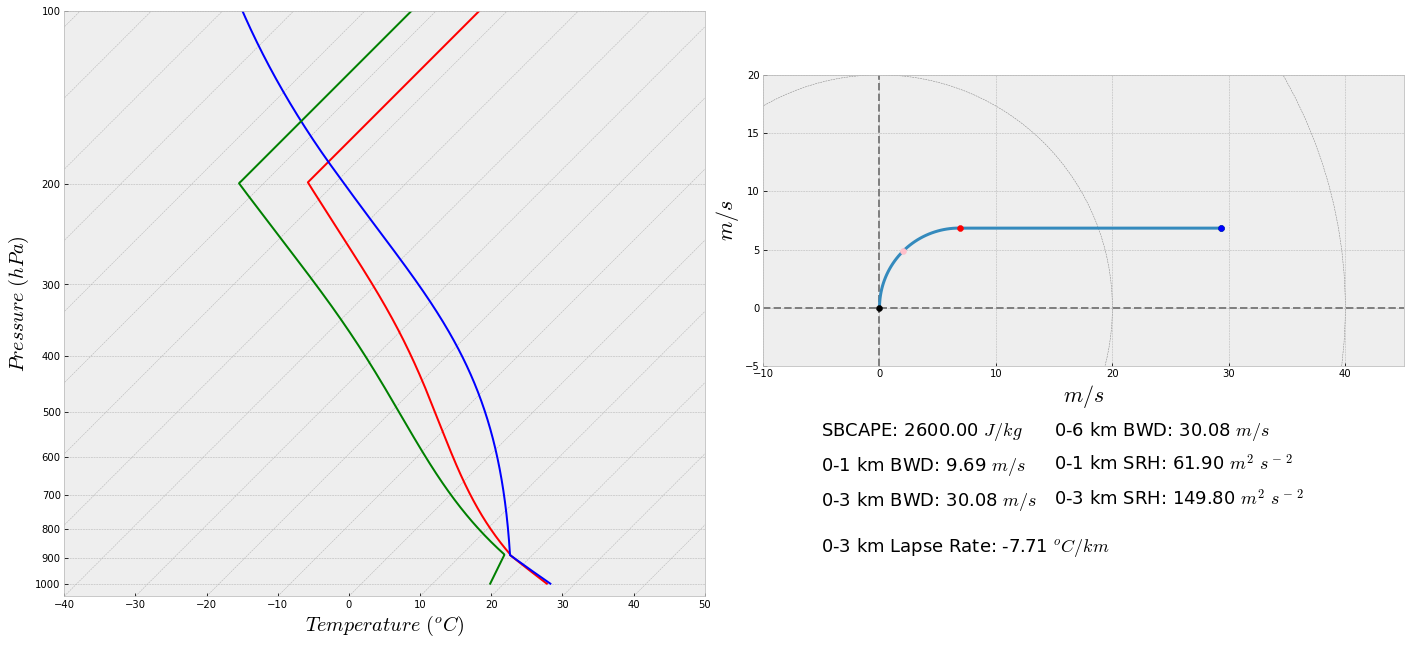

In [38]:
skew_t = t-273.15
skew_td = td-273.15
skew_parcel = t_p-273.15
skew_p = p/100

prof = profile.create_profile(profile='default',pres=skew_p[:-1],hght=z[:-1],tmpc=skew_t[:-1],dwpc=skew_td[:-1],
                             wspd=wind_spd[:-1],wdir = wind_dir[:-1],missing=-9999,strictQC=True)

sfcpcl = params.parcelx(prof,flag=1)
profile1 = sfcpcl.ttrace*units('degC')
pprofile1 = sfcpcl.ptrace*units('hPa')

srwind = params.bunkers_storm_motion(prof)
srwind_test = bunkers_storm_motion(p*units.Pa,uwind*units.meter/(units.second),vwind*units.meter/(units.second),z*units.meters)

sfccape = sfcpcl.bplus
sbcin = sfcpcl.bminus

sfc = prof.pres[prof.sfc]
p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))

sfc_1km_shear = winds.wind_shear(prof,pbot=sfc,ptop=p1km)
sfc1shear = utils.mag(sfc_1km_shear[0],sfc_1km_shear[1])
sfc_3km_shear = winds.wind_shear(prof,pbot=sfc,ptop=p3km)
sfc3shear = utils.mag(sfc_3km_shear[0],sfc_1km_shear[1])
sfc_6km_shear = winds.wind_shear(prof,pbot=sfc,ptop=p6km)
sfc6shear = utils.mag(sfc_6km_shear[0],sfc_6km_shear[1])

srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]

#Get lapse rates:
three_km = (np.where(z <= 3000)[-1][-1])
temp_3km = skew_t[three_km]

three_km_lr = ((temp_3km - skew_t[0])/(z[three_km] - z[0]))*1000

plt.style.use('bmh')
fig = plt.figure(figsize=(24,12))
fig.patch.set_facecolor('white')

gs = gridspec.GridSpec(8,4)

skew = SkewT(fig,rotation=45,subplot=gs[:,:2])

skew.plot(skew_p,skew_t,'r')
skew.plot(skew_p,skew_parcel,'b')
skew.plot(skew_p,skew_td,'g')

skew.ax.set_xlabel('$Temperature$ $(^oC)$',size=20)
skew.ax.set_ylabel('$Pressure$ $(hPa)$',size=20)

half_km_height = (np.where(z <= 500))[-1][-1]
one_km_height = (np.where(z <= 1000))[-1][-1]
two_km_height = (np.where(z <= 2000))[-1][-1]
three_km_height = (np.where(z <= 3000))[-1][-1]
five_km_height = (np.where(z <= 5000))[-1][-1]
six_km_height = (np.where(z <= 6000))[-1][-1]
eight_km_height = (np.where(z <= 8000))[-1][-1]

ax1 = fig.add_subplot(gs[:6,2:])
h = Hodograph(ax1)
h.add_grid(increment=20)
h.plot(uwind,vwind)
h.ax.scatter(uwind[0],vwind[0],color='black',zorder=10)
h.ax.scatter(uwind[half_km_height],vwind[half_km_height],color = 'pink',zorder=10)
h.ax.scatter(uwind[one_km_height],vwind[one_km_height],color = 'red',zorder = 10)
h.ax.scatter(uwind[three_km_height],vwind[three_km_height],color = 'green',zorder=10)
h.ax.scatter(uwind[six_km_height],vwind[six_km_height],color = 'blue',zorder=10)

h.ax.set_xlim([-10,45])
h.ax.set_ylim([-5,20])
h.ax.set_xlabel('$m/s$',size = 22)
h.ax.set_ylabel('$m/s$',size = 22)

h.ax.text(-5,-11,"SBCAPE: %1.2f $J/kg$" % cape0,fontsize=18)
#h.ax.text(-5,-13,"SBCIN: %1.2f $J/kg$" % sbcin,fontsize=18)
h.ax.text(-5,-14,"0-1 km BWD: %1.2f $m/s$" % sfc1shear,fontsize=18)
h.ax.text(-5,-17,"0-3 km BWD: %1.2f $m/s$" % sfc3shear,fontsize=18)
h.ax.text(15,-11,"0-6 km BWD: %1.2f $m/s$" % sfc6shear,fontsize=18)
h.ax.text(15,-14,"0-1 km SRH: %1.2f $m^2$ $s^-$$^2$" % srh1km,fontsize=18)
h.ax.text(15,-17,"0-3 km SRH: %1.2f $m^2$ $s^-$$^2$" % srh3km,fontsize=18)
#h.ax.text(13,-17,"LCL height: %1.2f $m$" % Z[zlcl],fontsize=18)
h.ax.text(-5,-21,"0-3 km Lapse Rate: %1.2f $^o$$C/km$" % three_km_lr,fontsize=18)

if save:
    intro = 'cm1_'
    save_png = '.png'
    plt.savefig(intro+name+save_png)
plt.show()

In [39]:
#Print the storm-relative wind from the hodograph. This can be used in the CM1 submission if you want a domain 
#translation to keep your storms relatively centered. 
print(srwind_test[2])

[17.574794231718293 6.142739143339977] meter / second


In [40]:
#Save to file for CM1 submission:

#Getting the variables together to put into a text file for an input_sounding file:
input_s = [z,th,qv*1000,uwind,vwind]
input_sounding_t = np.asarray(input_s)
input_sounding = input_sounding_t.transpose()

#Getting the first line for the file: surface pressure, surface theta, surface qv: 
first = [p[0]/100,th[0],qv[0]*1000]
first_line_t = np.asarray(first)
first_line = first_line_t.transpose()

#Save the file:
if save:
    save_txt = '.txt'
    np.savetxt(intro+name+save_txt,first,delimiter=' ',newline=' ')
    
    with open(intro+name+save_txt,"ab") as f:
        f.write(b"\n")
        np.savetxt(f,input_sounding,delimiter = ' ')